<a href="https://colab.research.google.com/github/otlvrzl/transfer_learning1/blob/main/pretrained_model_feature_extractor_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Enable TensorFlow 2.0
%tensorflow_version 2.x

In [ ]:
# Import Tensorflow
import tensorflow as tf
tf.__version__

'2.8.0'

In [ ]:
# Import TensorFlow datasets
import tensorflow_datasets as tfds
tfds.disable_progress_bar()

# Import Keras 
from tensorflow import keras
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam

# Import Numpy
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# Load train and validation datasets
(raw_train, raw_validation, raw_test), metadata = tfds.load(
    name='tf_flowers',
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'], # train, validation, test split of 8:1:1
    with_info=True,
    as_supervised=True)

local data directory. If you'd instead prefer to read directly from our public
GCS bucket (recommended if you're running on GCP), you can instead pass
`try_gcs=True` to `tfds.load` or set `data_dir=gs://tfds-data/datasets`.



Dataset tf_flowers downloaded and prepared to /root/tensorflow_datasets/tf_flowers/3.0.1. Subsequent calls will reuse this data.


In [ ]:
!ls -la /root/tensorflow_datasets/tf_flowers/3.0.1

total 227240
drwxr-xr-x 2 root root      4096 Mar  5 19:38 .
drwxr-xr-x 3 root root      4096 Mar  5 19:38 ..
-rw-r--r-- 1 root root      1566 Mar  5 19:38 dataset_info.json
-rw-r--r-- 1 root root        48 Mar  5 19:38 image.image.json
-rw-r--r-- 1 root root        40 Mar  5 19:38 label.labels.txt
-rw-r--r-- 1 root root 114154092 Mar  5 19:38 tf_flowers-train.tfrecord-00000-of-00002
-rw-r--r-- 1 root root 118513885 Mar  5 19:38 tf_flowers-train.tfrecord-00001-of-00002


In [ ]:
print("Total number of samples:",  metadata.splits['train'].num_examples)


Total number of samples: 3670


In [ ]:
metadata

tfds.core.DatasetInfo(
    name='tf_flowers',
    version=3.0.1,
    description='A large set of images of flowers',
    homepage='https://www.tensorflow.org/tutorials/load_data/images',
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=5),
    }),
    total_num_examples=3670,
    splits={
        'train': 3670,
    },
    supervised_keys=('image', 'label'),
    citation="""@ONLINE {tfflowers,
    author = "The TensorFlow Team",
    title = "Flowers",
    month = "jan",
    year = "2019",
    url = "http://download.tensorflow.org/example_images/flower_photos.tgz" }""",
    redistribution_info=,
)

In [ ]:
num_classes = metadata.features['label'].num_classes
num_train =  len(list(raw_train))
num_validation = len(list(raw_validation))
num_test = len(list(raw_test))

print("Number of classes:", num_classes)
print("Number of training samples:", num_train)
print("Number of validation samples:",  num_validation)
print("Number of test samples:", num_test)

Number of classes: 5
Number of training samples: 2936
Number of validation samples: 367
Number of test samples: 367


In [ ]:
# Inspect datasets before data preprocessing
print(raw_train)
print(raw_validation)
print(raw_test)

<PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>
<PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>
<PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>


In [ ]:
# Get labels / class names
class_names = np.array(metadata.features['label'].names)
print(class_names)

['dandelion' 'daisy' 'tulips' 'sunflowers' 'roses']


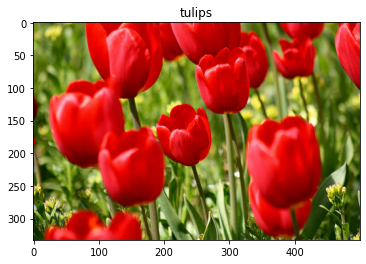

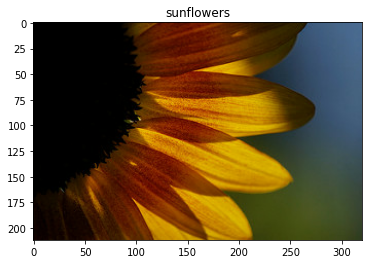

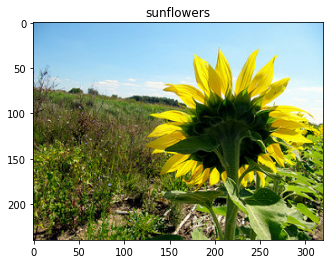

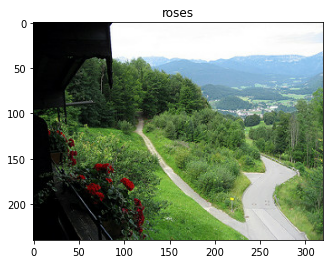

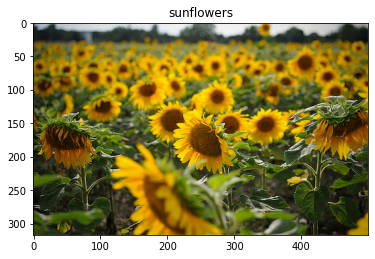

In [ ]:
label_names = metadata.features['label'].int2str

for image, label in raw_train.take(5):
  plt.figure()
  plt.imshow(image)
  plt.title(label_names(label))

In [ ]:
IMG_SIZE = 224 
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)

def format_example(image, label):
  image = tf.cast(image, tf.float32)
  image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
  image = image/255.0
  return image, label

In [ ]:
train = raw_train.map(format_example)
validation = raw_validation.map(format_example)
test = raw_test.map(format_example)

In [ ]:
def augment_data(image, label):
  image = tf.image.random_flip_left_right(image)
  image = tf.image.random_contrast(image, lower=0.0, upper=1.0)
  image = tf.stack(image, axis=0)
  image = tf.image.random_crop(image, size=[IMG_SIZE, IMG_SIZE, 3])
  return image, label

In [ ]:
train = train.map(augment_data)

In [ ]:
train

<MapDataset element_spec=(TensorSpec(shape=(224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [ ]:
validation

<MapDataset element_spec=(TensorSpec(shape=(224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [ ]:
BATCH_SIZE = 32
SHUFFLE_BUFFER_SIZE = 1000

train_batches = train.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE).repeat()
validation_batches = validation.batch(BATCH_SIZE).repeat()
test_batches = test.batch(BATCH_SIZE)

In [ ]:
# Inspect datasets after data preprocessing
print(train_batches)
print(validation_batches)
print(test_batches)

<RepeatDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>
<RepeatDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>
<BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>


In [ ]:
# Inspect a batch of data
for image_batch, label_batch in train_batches.take(1):
   pass

image_batch.shape

TensorShape([32, 224, 224, 3])

In [ ]:
# Set training parameters
NUM_EPOCHS = 10
steps_per_epoch = round(num_train)//BATCH_SIZE
validation_steps = round(num_validation)//BATCH_SIZE

In [ ]:
# Display training curves
def display_training_curves(history, title):
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']

  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs_range = range(NUM_EPOCHS)

  plt.plot(epochs_range, acc, label='Train accuracy')
  plt.plot(epochs_range, val_acc, label='Val accuracy')
  plt.title(title)
  plt.legend(loc='upper left')
  plt.figure()

  plt.show()

In [ ]:
def build_model_from_scratch():

  model = Sequential([
   # Must define the input shape in the first layer of the neural network
    Conv2D(filters=32, kernel_size=3, padding='same', activation='relu', input_shape=IMG_SHAPE),
    MaxPooling2D(pool_size=2),

    Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'),
    MaxPooling2D(pool_size=2),

    Flatten(),
    Dense(64, activation='relu'),
    Dense(num_classes, activation='softmax')
  ])

  return model

In [ ]:
simple_cnn_model = build_model_from_scratch()

In [ ]:
simple_cnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 56, 56, 64)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 200704)            0         
                                                                 
 dense (Dense)               (None, 64)                1

In [ ]:
def train_model(model):
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    history = model.fit(train_batches,
              epochs=NUM_EPOCHS, 
              validation_data=validation_batches,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps)
    
    return history

In [ ]:
%%time
history = train_model(simple_cnn_model)

Epoch 1/10
91/91 [==============================] - 17s 74ms/step - loss: 1.8404 - accuracy: 0.3695 - val_loss: 1.1848 - val_accuracy: 0.5199
Epoch 2/10
91/91 [==============================] - 8s 88ms/step - loss: 1.2303 - accuracy: 0.4886 - val_loss: 1.1769 - val_accuracy: 0.5199
Epoch 3/10
91/91 [==============================] - 8s 87ms/step - loss: 1.1764 - accuracy: 0.5003 - val_loss: 1.1099 - val_accuracy: 0.5682
Epoch 4/10
91/91 [==============================] - 7s 82ms/step - loss: 1.1185 - accuracy: 0.5382 - val_loss: 1.0486 - val_accuracy: 0.5909
Epoch 5/10
91/91 [==============================] - 7s 83ms/step - loss: 1.0522 - accuracy: 0.5671 - val_loss: 1.1520 - val_accuracy: 0.6051
Epoch 6/10
91/91 [==============================] - 8s 86ms/step - loss: 0.9704 - accuracy: 0.6216 - val_loss: 1.1342 - val_accuracy: 0.6222
Epoch 7/10
91/91 [==============================] - 7s 83ms/step - loss: 0.8755 - accuracy: 0.6632 - val_loss: 1.0474 - val_accuracy: 0.6506
Epoch 8/10
9

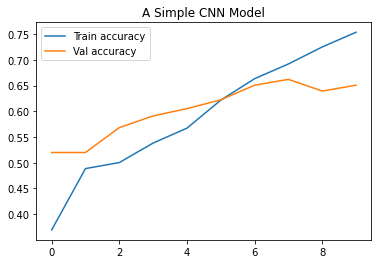

<Figure size 432x288 with 0 Axes>

In [ ]:
# Display training curve 
display_training_curves(history, "A Simple CNN Model")

In [ ]:
# Create base model from tf.keras pre-trained model MobileNetV2
base_model = MobileNetV2(input_shape=IMG_SHAPE,
                         weights="imagenet", 
                         include_top=False)

9420800/9406464 [==============================] - 0s 0us/step


In [ ]:
base_model.trainable = False

In [ ]:
base_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                              

In [ ]:
def build_mobilenetv2_model(base_model):
  model = Sequential([
      base_model,
      Conv2D(32, 3, activation='relu'),
      GlobalAveragePooling2D(),
      Dense(num_classes, activation='softmax')]
  )

  return model

In [ ]:
model = build_mobilenetv2_model(base_model)

In [ ]:
model.compile(optimizer= Adam(),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 conv2d_2 (Conv2D)           (None, 5, 5, 32)          368672    
                                                                 
 global_average_pooling2d (G  (None, 32)               0         
 lobalAveragePooling2D)                                          
                                                                 
 dense_2 (Dense)             (None, 5)                 165       
                                                                 
Total params: 2,626,821
Trainable params: 368,837
Non-trainable params: 2,257,984
_________________________________________________________________


In [ ]:
%%time
history = model.fit(train_batches,
                    epochs=NUM_EPOCHS,
                    validation_data=validation_batches,
                    steps_per_epoch=steps_per_epoch,
                    validation_steps=validation_steps)

Epoch 1/10
91/91 [==============================] - 11s 79ms/step - loss: 1.1275 - accuracy: 0.5539 - val_loss: 0.7016 - val_accuracy: 0.7415
Epoch 2/10
91/91 [==============================] - 8s 82ms/step - loss: 0.7505 - accuracy: 0.6791 - val_loss: 0.6097 - val_accuracy: 0.7557
Epoch 3/10
91/91 [==============================] - 8s 83ms/step - loss: 0.6051 - accuracy: 0.7600 - val_loss: 0.4636 - val_accuracy: 0.8494
Epoch 4/10
91/91 [==============================] - 7s 82ms/step - loss: 0.4579 - accuracy: 0.8333 - val_loss: 0.4472 - val_accuracy: 0.8608
Epoch 5/10
91/91 [==============================] - 8s 83ms/step - loss: 0.4269 - accuracy: 0.8375 - val_loss: 0.3994 - val_accuracy: 0.8722
Epoch 6/10
91/91 [==============================] - 7s 82ms/step - loss: 0.3880 - accuracy: 0.8578 - val_loss: 0.4534 - val_accuracy: 0.8750
Epoch 7/10
91/91 [==============================] - 7s 82ms/step - loss: 0.3581 - accuracy: 0.8616 - val_loss: 0.3900 - val_accuracy: 0.8864
Epoch 8/10
9

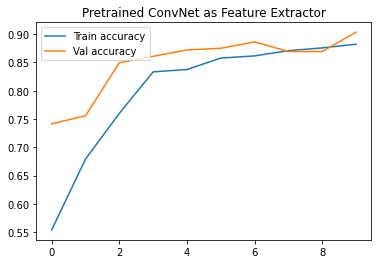

<Figure size 432x288 with 0 Axes>

In [ ]:
# Display training curve 
display_training_curves(history, "Pretrained ConvNet as Feature Extractor")

In [ ]:
# Unfreeze all layers in base model
base_model.trainable = True

In [ ]:
print("Number of layers in the base model: ", len(base_model.layers))

Number of layers in the base model:  154


In [ ]:
# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

In [ ]:
model.compile(loss='sparse_categorical_crossentropy',
              optimizer = Adam(1e-5),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 conv2d_2 (Conv2D)           (None, 5, 5, 32)          368672    
                                                                 
 global_average_pooling2d (G  (None, 32)               0         
 lobalAveragePooling2D)                                          
                                                                 
 dense_2 (Dense)             (None, 5)                 165       
                                                                 
Total params: 2,626,821
Trainable params: 2,230,277
Non-trainable params: 396,544
_________________________________________________________________


In [ ]:
INITIAL_EPOCHS = 10
FINE_TUNE_EPOCHS = 10
TOTAL_EPOCHS = INITIAL_EPOCHS + FINE_TUNE_EPOCHS #20

In [ ]:
%%time
history_fine = model.fit(train_batches,
                    epochs=TOTAL_EPOCHS,          #20
                    initial_epoch=INITIAL_EPOCHS, #10
                    validation_data=validation_batches,
                    steps_per_epoch=steps_per_epoch,
                    validation_steps=validation_steps)

Epoch 11/20
91/91 [==============================] - 17s 107ms/step - loss: 0.8048 - accuracy: 0.7332 - val_loss: 0.4348 - val_accuracy: 0.8693
Epoch 12/20
91/91 [==============================] - 9s 95ms/step - loss: 0.5109 - accuracy: 0.8110 - val_loss: 0.4378 - val_accuracy: 0.8693
Epoch 13/20
91/91 [==============================] - 9s 94ms/step - loss: 0.4701 - accuracy: 0.8264 - val_loss: 0.4277 - val_accuracy: 0.8864
Epoch 14/20
91/91 [==============================] - 9s 95ms/step - loss: 0.4300 - accuracy: 0.8357 - val_loss: 0.4157 - val_accuracy: 0.8920
Epoch 15/20
91/91 [==============================] - 9s 94ms/step - loss: 0.3738 - accuracy: 0.8564 - val_loss: 0.4128 - val_accuracy: 0.8835
Epoch 16/20
91/91 [==============================] - 9s 97ms/step - loss: 0.3775 - accuracy: 0.8533 - val_loss: 0.4064 - val_accuracy: 0.8778
Epoch 17/20
91/91 [==============================] - 9s 100ms/step - loss: 0.3289 - accuracy: 0.8802 - val_loss: 0.3874 - val_accuracy: 0.8835
Epo

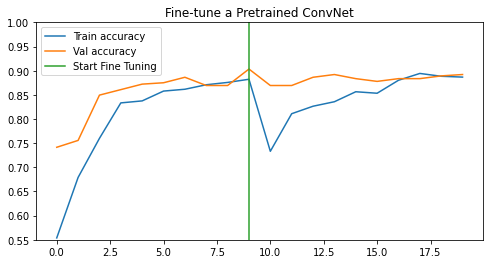

In [46]:
# Display training curve

acc = history.history['accuracy'] + history_fine.history['accuracy']
val_acc = history.history['val_accuracy'] + history_fine.history['val_accuracy']

plt.figure(figsize=(8, 4))

plt.plot(acc, label='Train accuracy')
plt.plot(val_acc, label='Val accuracy')
plt.ylim([0.8, 1])
plt.plot([NUM_EPOCHS-1, NUM_EPOCHS-1], plt.ylim(ymin=0.55), label='Start Fine Tuning')
plt.title("Fine-tune a Pretrained ConvNet")
plt.legend(loc='upper left')

plt.show()

In [47]:
# Evaluate the model on the test dataset
score = model.evaluate(test_batches, verbose=0)

# Print test accuracy
print('\n', 'Test accuracy:', score[1])


 Test accuracy: 0.9237056970596313


In [48]:
image_batch, label_batch = next(iter(test_batches))

image_batch = image_batch.numpy()
label_batch = label_batch.numpy()

predicted_batch = model.predict(image_batch)
predicted_batch = tf.squeeze(predicted_batch).numpy()

predicted_class_ids = np.argmax(predicted_batch, axis=-1)
predicted_class_names = class_names[predicted_class_ids]

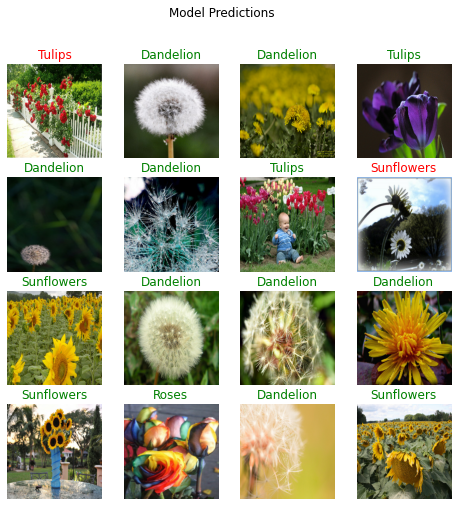

In [49]:
plt.figure(figsize=(8, 8))

# Display 16 test images with predictions
for i in range(16):
  plt.subplot(4, 4, i+1)
  # Display each image
  plt.imshow(image_batch[i])
  # Set title color: green if prediction correct and red if prediction incorrect
  title_color = "green" if predicted_class_ids[i] == label_batch[i] else "red"
  plt.title(predicted_class_names[i].title(), color=title_color)
  plt.axis('off')

_ = plt.suptitle("Model Predictions")